In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

from matplotlib import pyplot
#from scapy.all import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
! python -m spacy download en_core_web_md
! pip install transformers

2023-07-27 08:43:43.101941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 08:43:44.094953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-27 08:43:45.402490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-27 08:43:45.402996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
import en_core_web_md
nlp = en_core_web_md.load()
from tqdm.auto import tqdm,trange

import torch
import torch.nn as nn
import torch.nn.functional as F

#! pip install transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

# Set the tqdm text color:

from IPython.display import HTML, display

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #0B98C8 !important;}
            .widget-label {color: #0B98C8 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DF_TEACH_FILE ='/content/gdrive/MyDrive/COS23/Private_measuring/Meres2/forgalom5Server.csv'
DF_VALID_FILE = '/content/gdrive/MyDrive/COS23/Private_measuring/Meres/forgalom2.csv'

df_1 = pd.read_csv(DF_TEACH_FILE)
df_2 = pd.read_csv(DF_VALID_FILE)

df = pd.concat([df_1, df_2], ignore_index=True)

FileNotFoundError: ignored

DF_TEACH_FILE ='/content/gdrive/MyDrive/COS23/Private_measuring/Meres2/forgalom5Szerver.csv'
DF_VALID_FILE = '/content/gdrive/MyDrive/COS23/Private_measuring/Meres/forgalom2.csv'

df_1 = pd.read_csv(DF_TEACH_FILE)
df_2 = pd.read_csv(DF_VALID_FILE)

df = pd.concat([df_1, df_2], ignore_index=True)

In [ ]:
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,PcsCompu_22:46:4f,Broadcast,ARP,60,Who has 192.168.56.113? Tell 192.168.56.114
1,2,0.000028,PcsCompu_75:69:b0,PcsCompu_22:46:4f,ARP,42,192.168.56.113 is at 08:00:27:75:69:b0
2,3,0.000506,192.168.56.114,192.168.56.113,TCP,74,36610 > 502 [SYN] Seq=0 Win=64240 Len=0 MSS=...
3,4,0.000524,192.168.56.113,192.168.56.114,TCP,74,"502 > 36610 [SYN, ACK] Seq=0 Ack=1 Win=65160..."
4,5,0.001103,192.168.56.114,192.168.56.113,TCP,66,36610 > 502 [ACK] Seq=1 Ack=1 Win=64256 Len=...


In [ ]:
datas = []

for i in range(np.shape(df)[0]):
  datas.append(df['Source'][i] + ' ' + df['Destination'][i] + ' ' +df['Protocol'][i] + ' ' + str(df['Length'][i]))

df['datas'] = datas
df.insert(np.shape(df)[1], "IsAttack?", 0)

count = 0
for i in range(np.shape(df)[0]):
  a = df['Info'][i].split(' ')
  try:
    b = a.index('Exception' or 'reused' ) #reused,'refused'
    if a[b+1] == 'returned':
      df['IsAttack?'][i] = 1
      count +=1
  except:
    pass

print('\nWe found',count,'attacks')

df = df.drop(columns=['No.','Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'])
df.head()


We found 2459 attacks


,datas,IsAttack?
0,PcsCompu_22:46:4f Broadcast ARP 60,0
1,PcsCompu_75:69:b0 PcsCompu_22:46:4f ARP 42,0
2,192.168.56.114 192.168.56.113 TCP 74,0
3,192.168.56.113 192.168.56.114 TCP 74,0
4,192.168.56.114 192.168.56.113 TCP 66,0


In [ ]:
print("Total Null values count: ", df.isnull().sum().sum())
print("Total NaN values count: ", df.isna().sum().sum())

Total Null values count:  0
Total NaN values count:  0


In [ ]:
df['IsAttack?'].value_counts()

0    174207
1      2459
Name: IsAttack?, dtype: int64

In [ ]:
pd.DataFrame(df['datas'].value_counts()).head()

,datas
192.168.56.114 192.168.56.113 Modbus/TCP 78,51894
192.168.56.113 192.168.56.114 Modbus/TCP 78,43245
192.168.56.112 192.168.56.113 TCP 66,21104
192.168.56.114 192.168.56.113 TCP 66,14482
192.168.56.113 192.168.56.112 TCP 66,13721


In [ ]:
df.loc[df['datas'] == '192.168.56.114 192.168.56.113 Modbus/TCP 78'].head() # Emiatt lesz nagyon jó a becslés, mert rohadt rok az ismétlődő elem...

,datas,IsAttack?
5,192.168.56.114 192.168.56.113 Modbus/TCP 78,0
9,192.168.56.114 192.168.56.113 Modbus/TCP 78,0
12,192.168.56.114 192.168.56.113 Modbus/TCP 78,0
15,192.168.56.114 192.168.56.113 Modbus/TCP 78,0
18,192.168.56.114 192.168.56.113 Modbus/TCP 78,0


In [ ]:
datas_words=[]

for text in tqdm(df['datas']):
    with nlp.disable_pipes("tagger","parser","ner"):
        doc = nlp(text)
        datas_words.append([token.text.lower() for token in doc])

df['datas_words']=datas_words
df.head()

  0%|          | 0/176666 [00:00<?, ?it/s]

,datas,IsAttack?,datas_words
0,PcsCompu_22:46:4f Broadcast ARP 60,0,"[pcscompu_22:46:4f, broadcast, arp, 60]"
1,PcsCompu_75:69:b0 PcsCompu_22:46:4f ARP 42,0,"[pcscompu_75:69, :, b0, pcscompu_22:46:4f, arp..."
2,192.168.56.114 192.168.56.113 TCP 74,0,"[192.168.56.114, 192.168.56.113, tcp, 74]"
3,192.168.56.113 192.168.56.114 TCP 74,0,"[192.168.56.113, 192.168.56.114, tcp, 74]"
4,192.168.56.114 192.168.56.113 TCP 66,0,"[192.168.56.114, 192.168.56.113, tcp, 66]"


In [ ]:
class WordTokenizer():
    def __init__(self, tok_seqs, threshold=50):
        tok_counts={}

        for tok_seq in tqdm(tok_seqs):
            for tok in tok_seq:
                if not tok in tok_counts.keys():
                    tok_counts[tok]=1
                else:
                    tok_counts[tok]+=1

        self.vocab={'[PAD]':0,'[UNK]':1}
        for tok, val in tok_counts.items():
            if val>=threshold:
                self.vocab[tok]=len(self.vocab)

        print("The size of the dictionary:",len(self.vocab))
    def encode(self,seq):
        encoded=[]
        for tok in seq:
            if tok in self.vocab.keys():
                encoded.append(self.vocab[tok])
            else:
                encoded.append(1)
        return encoded

In [ ]:
word_tokenizer=WordTokenizer(df['datas_words'])
df['word_encoded']=[word_tokenizer.encode(seq) for seq in tqdm(df['datas_words'])]
df['word_length']=[len(seq) for seq in tqdm(df['datas_words'])]

  0%|          | 0/176666 [00:00<?, ?it/s]

The size of the dictionary: 43


  0%|          | 0/176666 [00:00<?, ?it/s]

  0%|          | 0/176666 [00:00<?, ?it/s]

In [ ]:
Class_encoding={'0':0,'1':1}
df['encoded_sentiment']=df['IsAttack?']
df

,datas,IsAttack?,datas_words,word_encoded,word_length,encoded_sentiment
0,PcsCompu_22:46:4f Broadcast ARP 60,0,"[pcscompu_22:46:4f, broadcast, arp, 60]","[1, 1, 2, 3]",4,0
1,PcsCompu_75:69:b0 PcsCompu_22:46:4f ARP 42,0,"[pcscompu_75:69, :, b0, pcscompu_22:46:4f, arp...","[4, 5, 6, 1, 2, 7]",6,0
2,192.168.56.114 192.168.56.113 TCP 74,0,"[192.168.56.114, 192.168.56.113, tcp, 74]","[8, 9, 10, 11]",4,0
3,192.168.56.113 192.168.56.114 TCP 74,0,"[192.168.56.113, 192.168.56.114, tcp, 74]","[9, 8, 10, 11]",4,0
4,192.168.56.114 192.168.56.113 TCP 66,0,"[192.168.56.114, 192.168.56.113, tcp, 66]","[8, 9, 10, 12]",4,0
...,...,...,...,...,...,...
176661,192.168.56.1 239.255.255.250 SSDP 209,0,"[192.168.56.1, 239.255.255.250, ssdp, 209]","[19, 20, 21, 24]",4,0
176662,192.168.56.113 192.168.56.100 DHCP 331,0,"[192.168.56.113, 192.168.56.100, dhcp, 331]","[9, 25, 26, 27]",4,0
176663,192.168.56.100 192.168.56.113 DHCP 590,0,"[192.168.56.100, 192.168.56.113, dhcp, 590]","[25, 9, 26, 28]",4,0
176664,PcsCompu_75:69:b0 PcsCompu_d7:d4:36 ARP 42,0,"[pcscompu_75:69, :, b0, pcscompu_d7, :, d4:36,...","[4, 5, 6, 1, 5, 1, 2, 7]",8,0


In [ ]:
df = df.sample(frac=1)
train_df=df[:160000]
dev_df=df[160000:]
print(train_df['encoded_sentiment'].value_counts())
print()
print(dev_df['encoded_sentiment'].value_counts())

0    157777
1      2223
Name: encoded_sentiment, dtype: int64

0    16430
1      236
Name: encoded_sentiment, dtype: int64


## Batch iterator:

In [ ]:
use_cuda = torch.cuda.is_available()
def to_cuda(var):
    if use_cuda:
        return var.cuda()
    return var

def batch_iterator(df, batch_size, shuffle=True, word_piece=False):
    if batch_size==0:
        starts=[0]
        batch_size=len(df)
    else:
        starts=np.arange(0, len(df), batch_size)
        if shuffle:
            np.random.shuffle(starts)

    for start in starts:
        batch = df[start:start+batch_size]
        bs = min(batch_size,len(df)-start)

        if word_piece:
            batch_len = batch["word_piece_length"].max()
        else:
            batch_len = batch["word_length"].max()

        input_tensor = torch.zeros((bs, batch_len)).long()

        if word_piece:
            for idx, (seq, seq_len) in enumerate(zip(list(batch["word_piece_encoded"]),list(batch["word_piece_length"]))):
                input_tensor[idx, :seq_len] = torch.LongTensor(seq)
        else:
            for idx, (seq, seq_len) in enumerate(zip(list(batch["word_encoded"]),list(batch["word_length"]))):
                input_tensor[idx, :seq_len] = torch.LongTensor(seq)

        sentiment_tensor = torch.LongTensor(list(batch["encoded_sentiment"]))

        yield to_cuda(input_tensor), to_cuda(sentiment_tensor)

## ***Models***

### LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, params):
        super(LSTM, self).__init__()

        default_params={
            #"vocab_size":len(data.vocab)+1, <-- nincs default
            "embedding_dim":50,
            "lstm_hidden_dim":100,
            "number_of_tags":2,
            "num_layers":1,
            "dropout": 0,
            "bidirectional": False
        }
        for key in default_params:
            params[key] = params.get(key, default_params[key])

        self.embedding = nn.Embedding(params["vocab_size"], params["embedding_dim"])

        self.lstm = nn.LSTM(params["embedding_dim"],
                            params["lstm_hidden_dim"],
                            batch_first = True,
                            num_layers = params["num_layers"],
                            dropout = params["dropout"],
                            bidirectional = params["bidirectional"])

        self.fc = nn.Linear(params["lstm_hidden_dim"], params["number_of_tags"])

    def forward(self, batch):
        emb = self.embedding(batch)

        output, (h_t, c_t) = self.lstm(emb)

        out = self.fc(h_t).float()[0]

        return out

### 1D convolutions

In [ ]:
class Conv1dNet(nn.Module):
    def __init__(self, params):
        super(Conv1dNet, self).__init__()

        default_params={
            #"vocab_size":len(data.vocab)+1, <-- nincs default
            "embedding_dim":50,
            "feature_size":20,
            "window_sizes":[3,5,7,9],
            "number_of_tags": 2,
            "dropout": 0
        }
        for key in default_params:
            params[key] = params.get(key, default_params[key])

        self.dropout_rate = params["dropout"]

        self.embedding = nn.Embedding(params["vocab_size"], params["embedding_dim"])

        self.convs = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=params["embedding_dim"],
                                        out_channels=params["feature_size"],
                                        kernel_size=h),
                              nn.BatchNorm1d(num_features=params["feature_size"]),
                              nn.ReLU(),
                              nn.AdaptiveAvgPool1d(1))
                     for h in params["window_sizes"]])

        self.fc = nn.Linear(params["feature_size"]*len(params["window_sizes"]), params["number_of_tags"])

    def forward(self, batch):
        emb = self.embedding(batch)
        emb = emb.permute(0, 2, 1)

        output = [conv(emb) for conv in self.convs]
        out = torch.cat(output, dim=1)
        out = out.view(-1, out.size(1))

        out = F.dropout(input=out, p=self.dropout_rate)
        out = self.fc(out)
        return out

### BERT

In [ ]:
class BERT(BertForSequenceClassification):
    def forward(self, batch):
        return super(BERT, self).forward(batch,to_cuda(batch!=0))[0].float()

## ***Training loop***

In [ ]:
#Az eredmények kirajzolásához
def general_plot(ys, xlabel="", ylabel="", title="", size=(5,5), labels=[]):
    pyplot.rcParams["figure.figsize"] = [size[1], size[0]]

    ax = pyplot.subplot(111)
    if labels==[]:
        for y in ys:
            print(range(len(y)), y)
            pyplot.plot(range(len(y)), y, marker='.')
    else:
        for i in range(len(ys)):
            pyplot.plot(range(len(ys[i])), ys[i], marker='.', label=labels[i])
        ax.legend()
    ax.tick_params(axis='x', colors='#0B98C8')
    ax.tick_params(axis='y', colors='#0B98C8')
    ax.yaxis.label.set_color('#0B98C8')
    ax.xaxis.label.set_color('#0B98C8')
    ax.set_facecolor('#293340')
    ax.title.set_color('#0B98C8')
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.title(title)

    #Feliratok az x tengelyen
    pyplot.xticks([i+1 for i in range(len(ys[0])) if  i % max(int(len(ys[0]) / (2*size[1])),1)==0])

    pyplot.show()

In [ ]:
class RunningAverage():
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        if self.steps==0:
            return 0
        else:
            return self.total / float(self.steps)

def classify(output):
    res=[]
    for p in output:
        res.append(np.argmax(p))
    return res

def get_results(model, iterator):
    res=[]
    sent=[]
    for input_batch, sentiment in iterator:
        output_batch = model(input_batch)
        result = classify(output_batch.data.cpu().numpy())

        res += result
        sent += list(sentiment.cpu().numpy().reshape(len(input_batch)))
    return res, sent

def get_accuracy(results, labels):
    correct = np.sum(np.equal(labels, results))
    alles = len(labels)

    return correct/alles*100

def train(model, train_df, dev_df, batch_size, epochs, word_piece=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    avg_losses=[]
    train_accuracies=[]
    dev_accuracies=[]
    train_acc = 0
    dev_acc = 0

    t = trange(epochs)
    for i in t:
        #-----TRAINING-----
        model.train()
        loss_avg = RunningAverage()

        for input_batch, sentiment in batch_iterator(train_df, batch_size, word_piece=word_piece):
            output_batch = model(input_batch)
            #print(output_batch)
            loss = loss_fn(output_batch, sentiment)
            loss_avg.update(loss.item())

            loss.backward()

            optimizer.step()
            model.zero_grad()
            optimizer.zero_grad()
            t.set_postfix(accOnTrain="{:05.2f}%".format(train_acc), accOnDev='{:05.2f}%'.format(dev_acc), loss='{:05.3f}'.format(loss_avg()))

        avg_losses.append(loss_avg())

        #-----EVALUATING-----
        model.eval()

        train_results, train_sentiments = get_results(model, batch_iterator(train_df, batch_size, shuffle=False, word_piece=word_piece))
        train_acc = get_accuracy(train_results, train_sentiments)
        train_accuracies.append(train_acc)

        dev_results, dev_sentiments = get_results(model, batch_iterator(dev_df, batch_size, shuffle=False, word_piece=word_piece))
        dev_acc = get_accuracy(dev_results, dev_sentiments)
        dev_accuracies.append(dev_acc)

        #print("Accuracy on train data: {:05.2f}%".format(train_acc))

        #print("Accuracy on dev data: {:05.2f}%".format(dev_acc))

        t.set_postfix(accOnTrain="{:05.2f}%".format(train_acc), accOnDev='{:05.2f}%'.format(dev_acc), loss='{:05.3f}'.format(loss_avg()))

    general_plot([avg_losses], 'epoch', 'loss', 'Average loss of each epoch', (8,15))
    general_plot([train_accuracies,dev_accuracies], 'epoch', 'accuracy', 'Accuracy after each epoch', (8,15), ['train acc','val acc'])
    return dev_accuracies

## ***Training***

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.004732705638492405, 0.00020771896637004518, 0.00020126956624674897, 0.00019814405604586582, 0.00022072117759689328, 0.00019956027294245753, 0.0002022908174540311, 0.00022383806221795629, 0.0001964383277031645, 0.00020326463537757356, 0.00021921689798204636, 0.00019423846436679272, 0.00020975657397390962, 0.0002284684273896241, 0.0002320727269039094, 0.00018555352975305986, 0.0002180311253296982, 0.00020145813322452772, 0.00032731207723699584, 0.0001868254797341881]


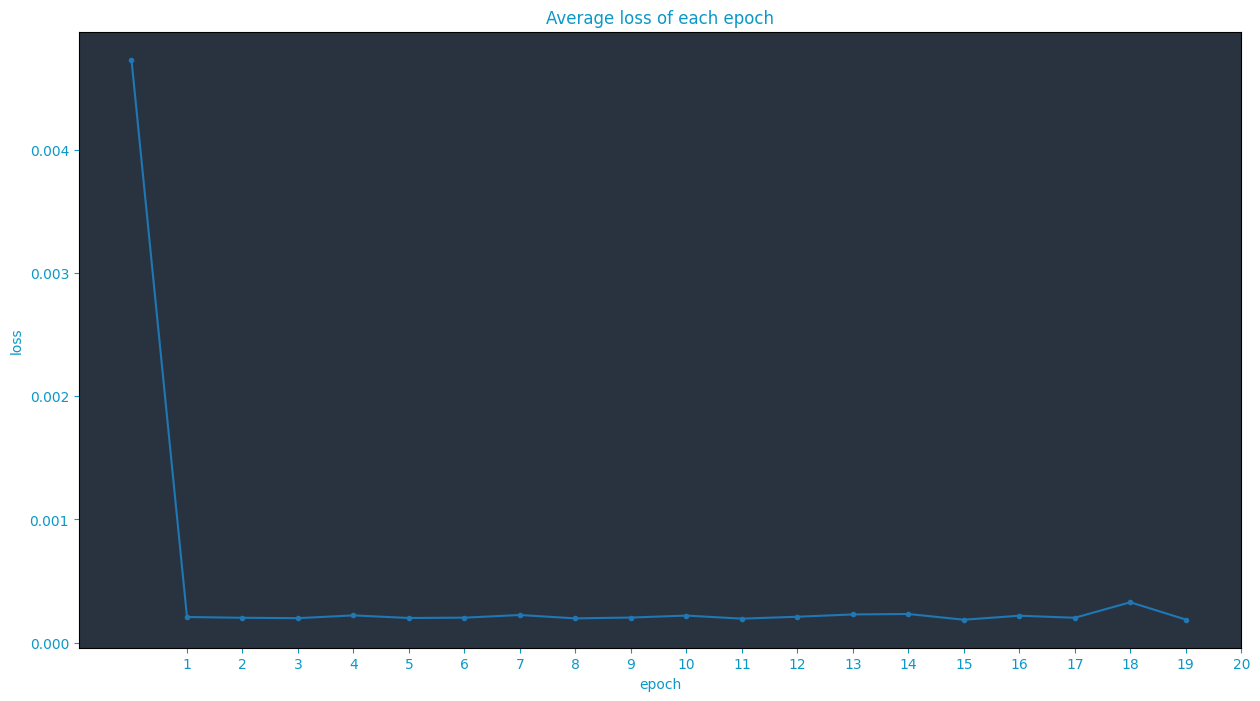

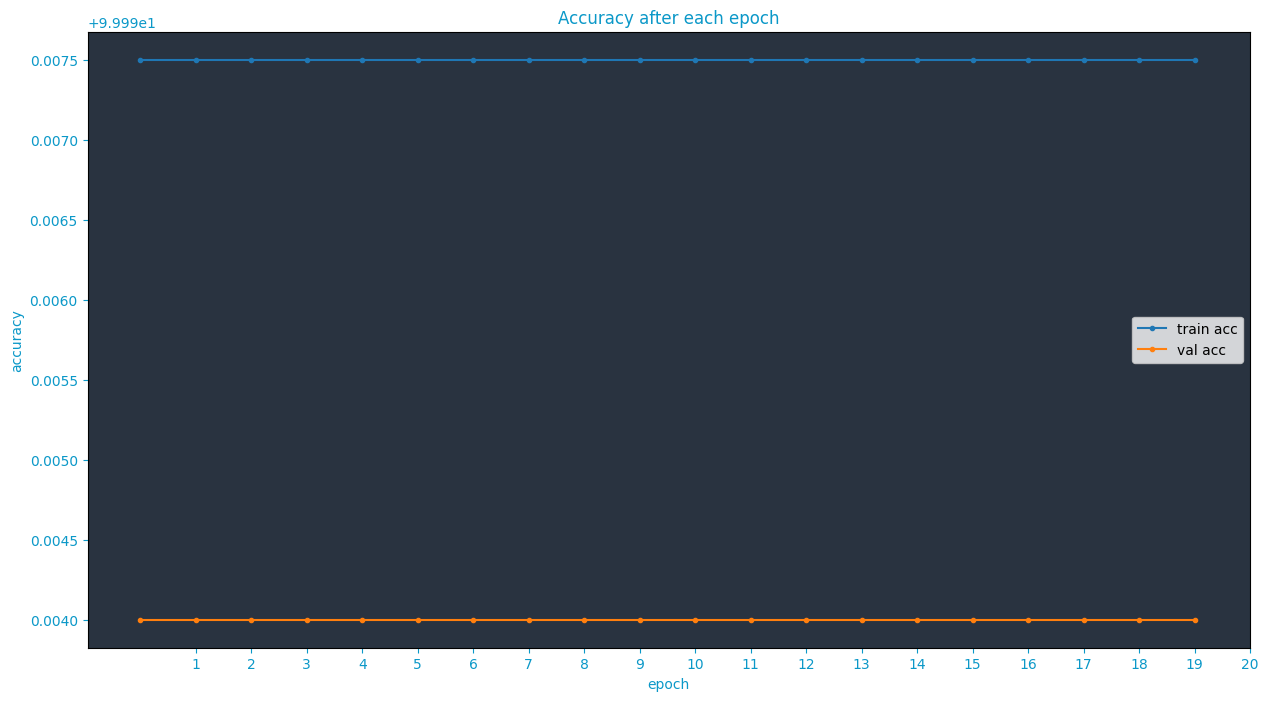

In [ ]:
learning_rate=0.001

lstm_model=LSTM(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": True
    }
)
lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, train_df, dev_df, batch_size=50, epochs=20)
del lstm_model

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.0014057014445240411, 0.0003528171339149111, 0.00025728884026134823, 0.00025557784046710915, 0.0003093735366787981, 0.00029883835972360095, 0.00022276744421106302, 0.00032009433973844955, 0.00028628787391534794, 0.00032962196090420977, 0.00046496123551886093, 0.000351926860059161, 0.0003845427451090308, 0.000437723591724643, 0.00042743343147847156, 0.0004013722398457535, 0.0003306019885226881, 0.000298751064619313, 0.0002747344764926295, 0.00029245343811020954]


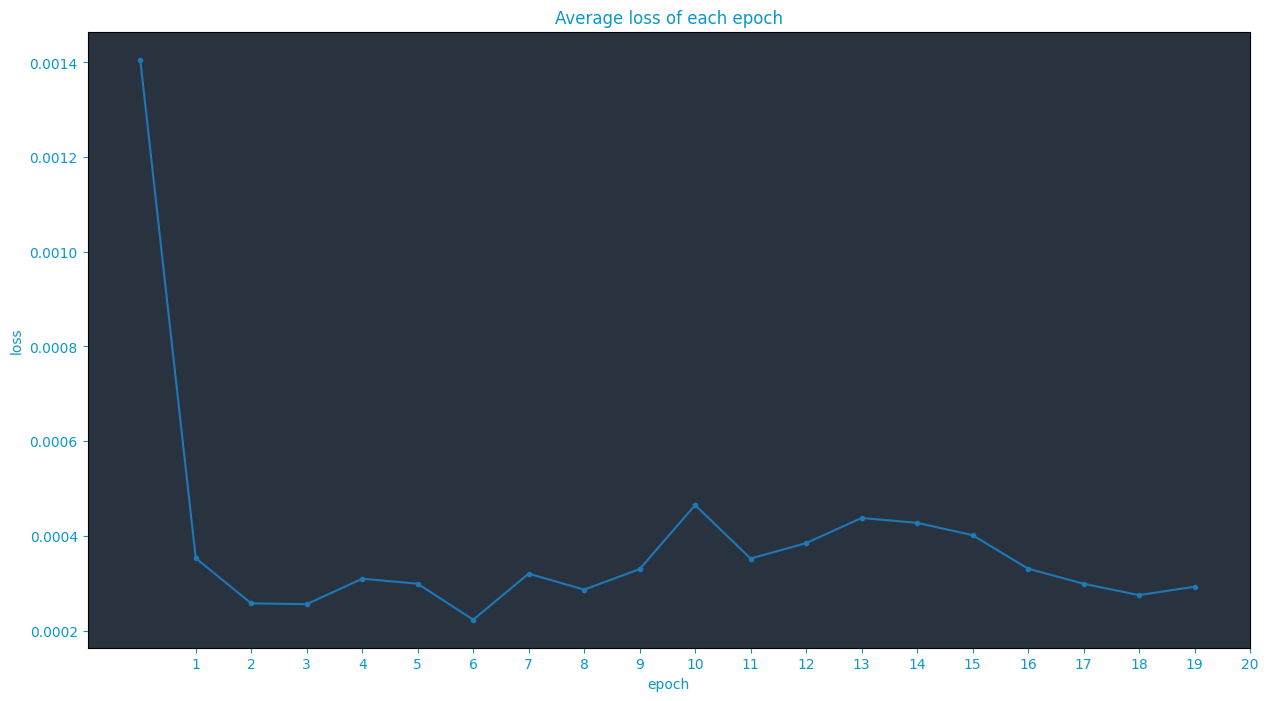

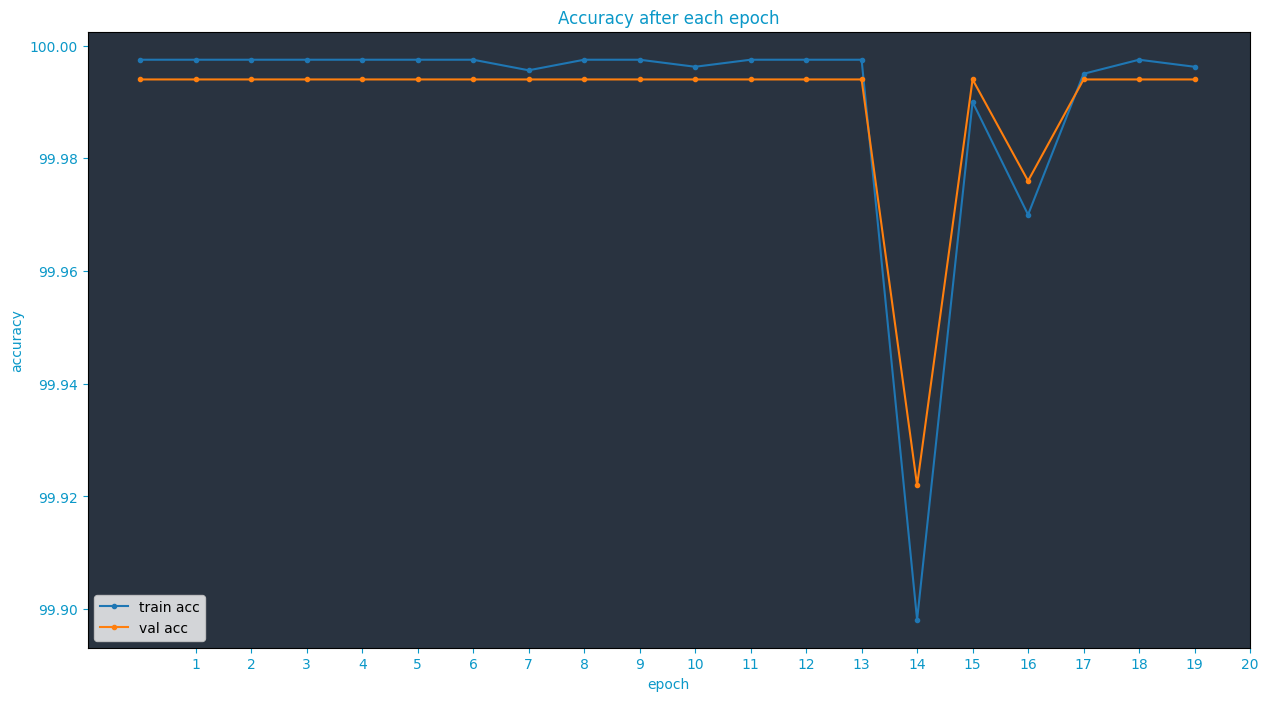

In [ ]:
learning_rate=0.005

conv1d_model=Conv1dNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim":50,
        "feature_size":50,
        "window_sizes":[3,5],
        "number_of_tags": 2,
        "dropout": 0.2
    }
)
conv1d_model=to_cuda(conv1d_model)

conv1d_dev_accuracies = train(conv1d_model, train_df, dev_df, batch_size=50, epochs=20)
del conv1d_model

In [ ]:
!ls '/content/gdrive/MyDrive/Colab Notebooks/'

COS23_2.ipynb	DF.csv			     forgalomServerSynFlood1.gsheet
COS23.ipynb	forgalom2.csv		     forgalomSynFloodToServerRandIP.csv
COS23_v3.ipynb	forgalom5Server.csv	     Private_measuring
cos23_v4.ipynb	forgalomServerSynFlood1.csv


***Ezt az adatkészletet kell használni***

In [ ]:
file_name_1 = '/content/gdrive/MyDrive/Colab Notebooks/Private_measuring/MeresSyn/forgalomServerSynFlood1.csv'
file_name_2 = '/content/gdrive/MyDrive/Colab Notebooks/Private_measuring/MeresSyn/forgalomSynFloodToServerRandIP.csv'

file_1 = pd.read_csv(file_name_1)
file_2 = pd.read_csv(file_name_2)

datas = []
for i in range(np.shape(file_1)[0]):
  datas.append(file_1['Source'][i] + ' ' + file_1['Destination'][i] + ' ' +file_1['Protocol'][i] + ' ' + str(file_1['Length'][i]))

file_1['datas'] = datas
file_1.insert(np.shape(file_1)[1], "IsAttack?", 0)

datas = []
for i in range(np.shape(file_2)[0]):
  datas.append(file_2['Source'][i] + ' ' + file_2['Destination'][i] + ' ' +file_2['Protocol'][i] + ' ' + str(file_2['Length'][i]))

file_2['datas'] = datas
file_2.insert(np.shape(file_2)[1], "IsAttack?", 1)

In [ ]:
DF_1 ='/content/gdrive/MyDrive/Colab Notebooks/Private_measuring/Meres2/forgalom5Server.csv'
DF_2 = '/content/gdrive/MyDrive/Colab Notebooks/Private_measuring/Meres/forgalom2.csv'

df_1 = pd.read_csv(DF_1)
df_2 = pd.read_csv(DF_2)

df = pd.concat([df_1, df_2], ignore_index=True)

datas = []
for i in range(np.shape(df)[0]):
  datas.append(df['Source'][i] + ' ' + df['Destination'][i] + ' ' +df['Protocol'][i] + ' ' + str(df['Length'][i]))

df['datas'] = datas
df.insert(np.shape(df)[1], "IsAttack?", 0)

count = 0
for i in range(np.shape(df)[0]):
  a = df['Info'][i].split(' ')
  try:
    b = a.index('Exception' or 'reused' ) #reused,'refused'
    if a[b+1] == 'returned':
      df['IsAttack?'][i] = 1
      count +=1
  except:
    pass

df = pd.concat([df, file_1, file_2], ignore_index=True)
# Eddig ugyan az
df = df.drop(columns=['No.','Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info'], axis=1)
np.shape(df)

(472663, 2)

In [ ]:
#df['word_encoded_str'] = df['word_encoded'].astype(str)
df_deduplicated = df.drop_duplicates(ignore_index=True)
np.shape(df_deduplicated)

(266686, 2)

In [ ]:
df_deduplicated.sample(frac=1).head()

,datas,IsAttack?
193210,210.11.140.185 192.168.56.113 TCP 54,1
140518,14.221.153.215 192.168.56.113 TCP 54,1
250796,176.137.215.247 192.168.56.113 TCP 54,1
75150,88.64.227.9 192.168.56.113 TCP 60,0
34916,3.156.6.135 192.168.56.113 TCP 60,0


In [ ]:
df_deduplicated['IsAttack?'].value_counts()

0    133366
1    133320
Name: IsAttack?, dtype: int64

In [ ]:
df = df_deduplicated.copy()
datas_words=[]

for text in tqdm(df['datas']):
    with nlp.disable_pipes("tagger","parser","ner"):
        doc = nlp(text)
        datas_words.append([token.text.lower() for token in doc])

df['datas_words']=datas_words
df.head()

  0%|          | 0/266686 [00:00<?, ?it/s]

,datas,IsAttack?,datas_words
0,PcsCompu_22:46:4f Broadcast ARP 60,0,"[pcscompu_22:46:4f, broadcast, arp, 60]"
1,PcsCompu_75:69:b0 PcsCompu_22:46:4f ARP 42,0,"[pcscompu_75:69, :, b0, pcscompu_22:46:4f, arp..."
2,192.168.56.114 192.168.56.113 TCP 74,0,"[192.168.56.114, 192.168.56.113, tcp, 74]"
3,192.168.56.113 192.168.56.114 TCP 74,0,"[192.168.56.113, 192.168.56.114, tcp, 74]"
4,192.168.56.114 192.168.56.113 TCP 66,0,"[192.168.56.114, 192.168.56.113, tcp, 66]"


In [ ]:
word_tokenizer=WordTokenizer(df['datas_words'])
df['word_encoded']=[word_tokenizer.encode(seq) for seq in tqdm(df['datas_words'])]
df['word_length']=[len(seq) for seq in tqdm(df['datas_words'])]

Class_encoding={'0':0,'1':1}
df['encoded_sentiment']=df['IsAttack?']
df.head()

  0%|          | 0/266686 [00:00<?, ?it/s]

The size of the dictionary: 6


  0%|          | 0/266686 [00:00<?, ?it/s]

  0%|          | 0/266686 [00:00<?, ?it/s]

,datas,IsAttack?,datas_words,word_encoded,word_length,encoded_sentiment
0,PcsCompu_22:46:4f Broadcast ARP 60,0,"[pcscompu_22:46:4f, broadcast, arp, 60]","[1, 1, 1, 2]",4,0
1,PcsCompu_75:69:b0 PcsCompu_22:46:4f ARP 42,0,"[pcscompu_75:69, :, b0, pcscompu_22:46:4f, arp...","[1, 1, 1, 1, 1, 1]",6,0
2,192.168.56.114 192.168.56.113 TCP 74,0,"[192.168.56.114, 192.168.56.113, tcp, 74]","[1, 3, 4, 1]",4,0
3,192.168.56.113 192.168.56.114 TCP 74,0,"[192.168.56.113, 192.168.56.114, tcp, 74]","[3, 1, 4, 1]",4,0
4,192.168.56.114 192.168.56.113 TCP 66,0,"[192.168.56.114, 192.168.56.113, tcp, 66]","[1, 3, 4, 1]",4,0


In [ ]:
np.shape(df)

(266686, 6)

In [ ]:
df = df.sample(frac=1)
train_df=df[:200000]
dev_df=df[200000:]
print(train_df['encoded_sentiment'].value_counts())
print()
print(dev_df['encoded_sentiment'].value_counts())

0    100104
1     99896
Name: encoded_sentiment, dtype: int64

1    33424
0    33262
Name: encoded_sentiment, dtype: int64


  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.003920668290274989, 0.00021708659394761298, 0.00019052464601190878, 0.0001808132521788366, 0.0001477056760515083, 0.0001971644413102993, 0.00015959698113753083, 0.0001456681249415519, 0.0001668436109198872, 0.0001468977151317299, 0.00016664353537319343, 0.00014071869819906447, 0.00013787787882048975, 0.00017097514784910616, 0.00014323569068126041, 0.0001432462097189342, 0.00013393750505362334, 0.00014826318721983923, 0.00015046524203065292, 0.0001374342546220575]


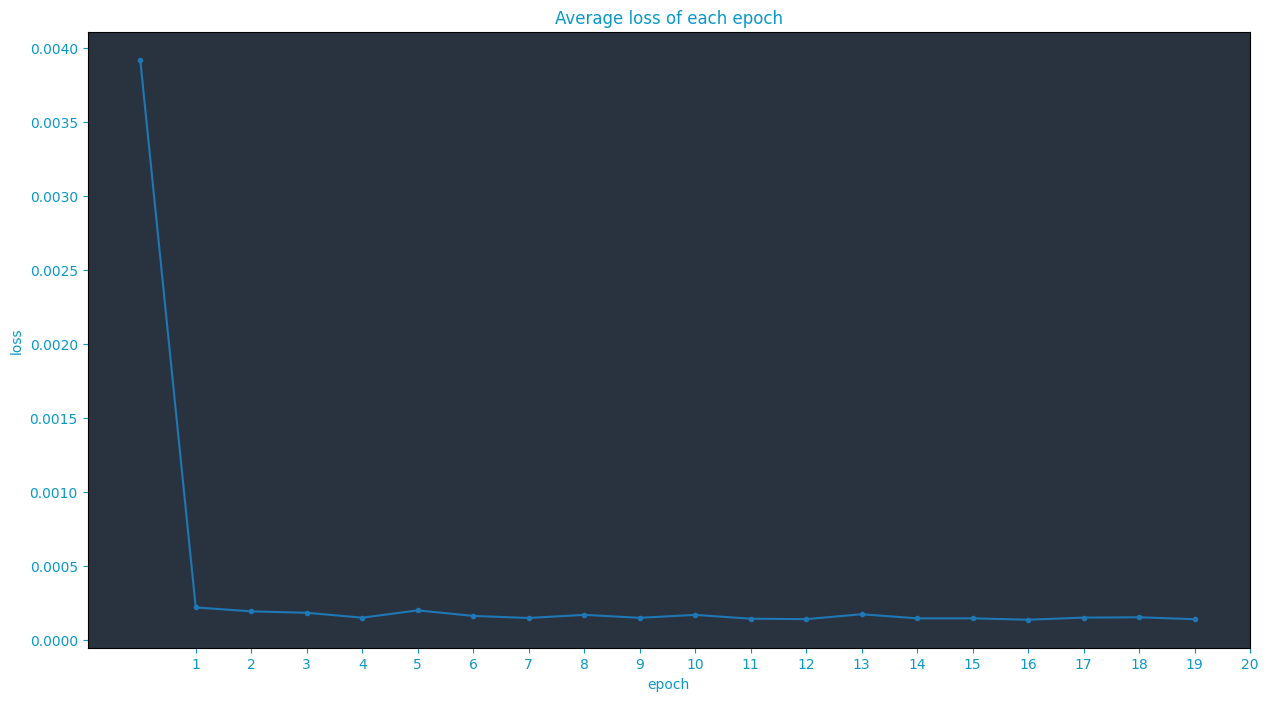

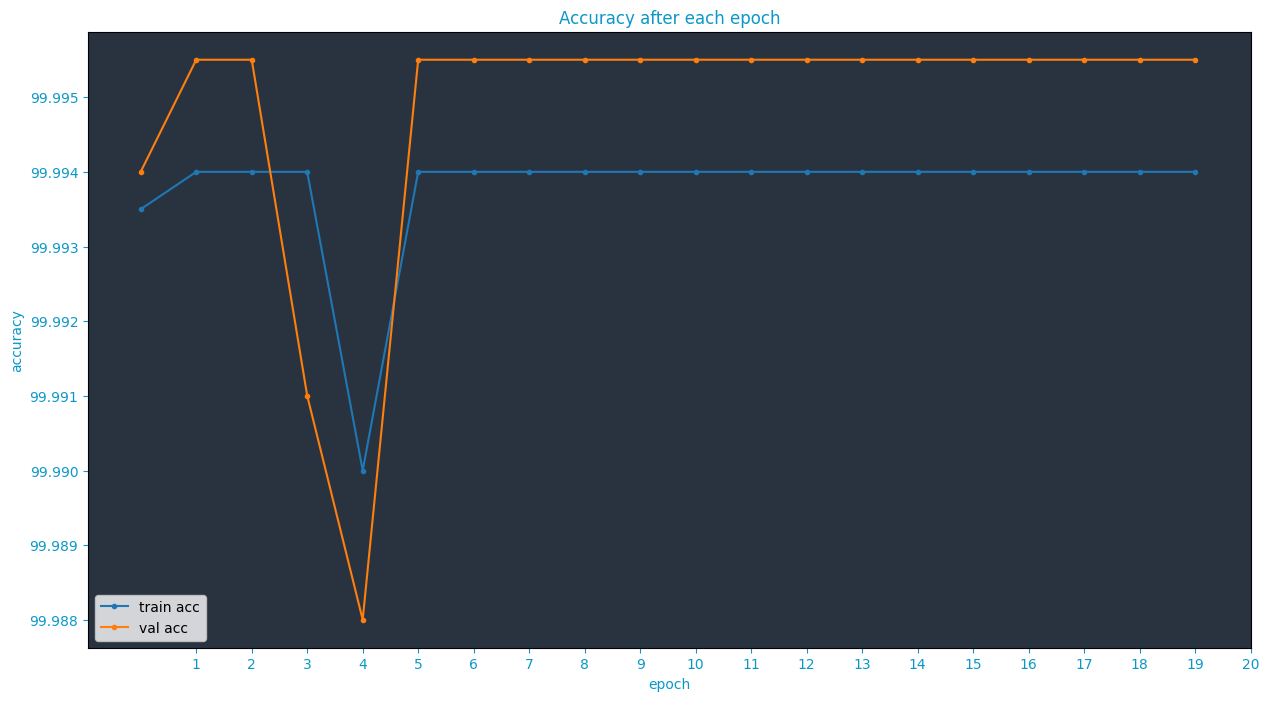

In [ ]:
learning_rate=0.001

lstm_model=LSTM(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim": 50,
        "lstm_hidden_dim": 50,
        "number_of_tags": 2,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": True
    }
)
lstm_model=to_cuda(lstm_model)

lstm_dev_accuracies = train(lstm_model, train_df, dev_df, batch_size=50, epochs=20)
del lstm_model

  0%|          | 0/20 [00:00<?, ?it/s]

range(0, 20) [0.002017274628334235, 0.00023899368584056902, 0.00015760242394208035, 0.000194085569346214, 0.0002472531956555031, 0.00016157382639177343, 0.00023347784339836154, 0.00021204200837074793, 0.0002345837396000796, 0.0002598046315089402, 0.00020315267915747094, 0.00016733419745934696, 0.00015825606011358605, 0.00018471853270864147, 0.00020486855417283046, 0.00017912481592622664, 0.00025285394020640095, 0.00019390613189574236, 0.00021585932882643667, 0.000142980268252612]


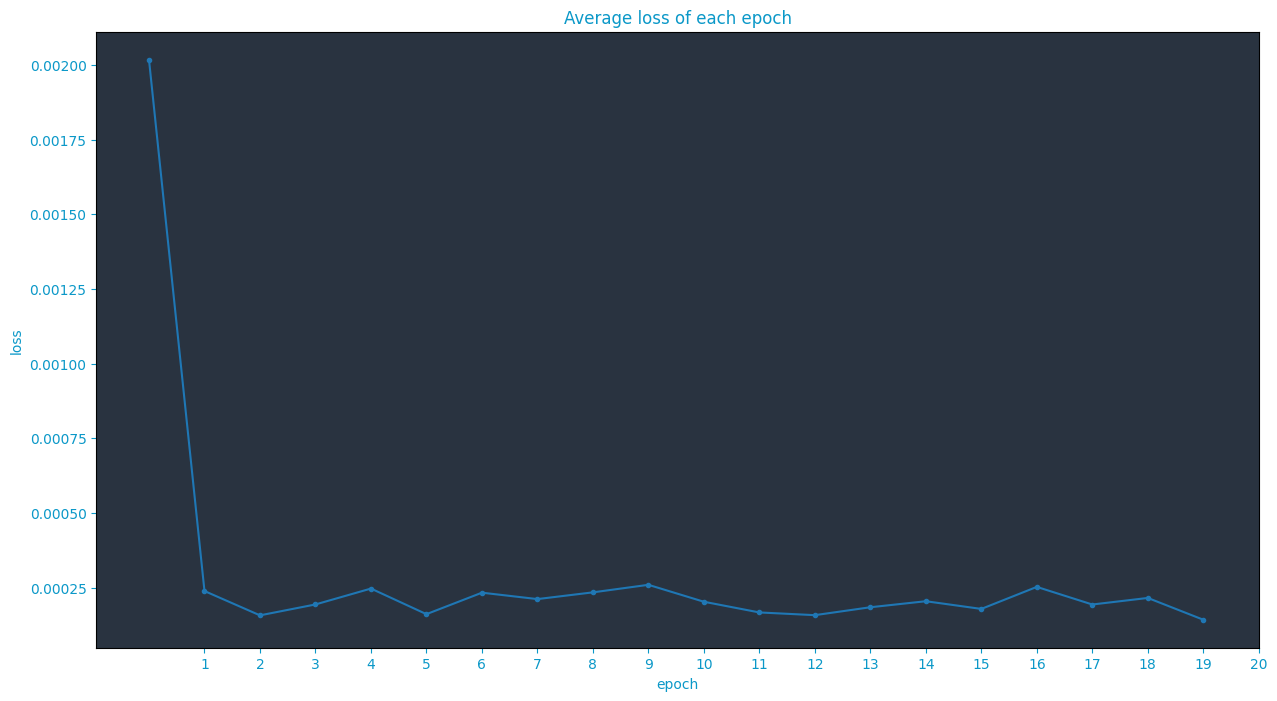

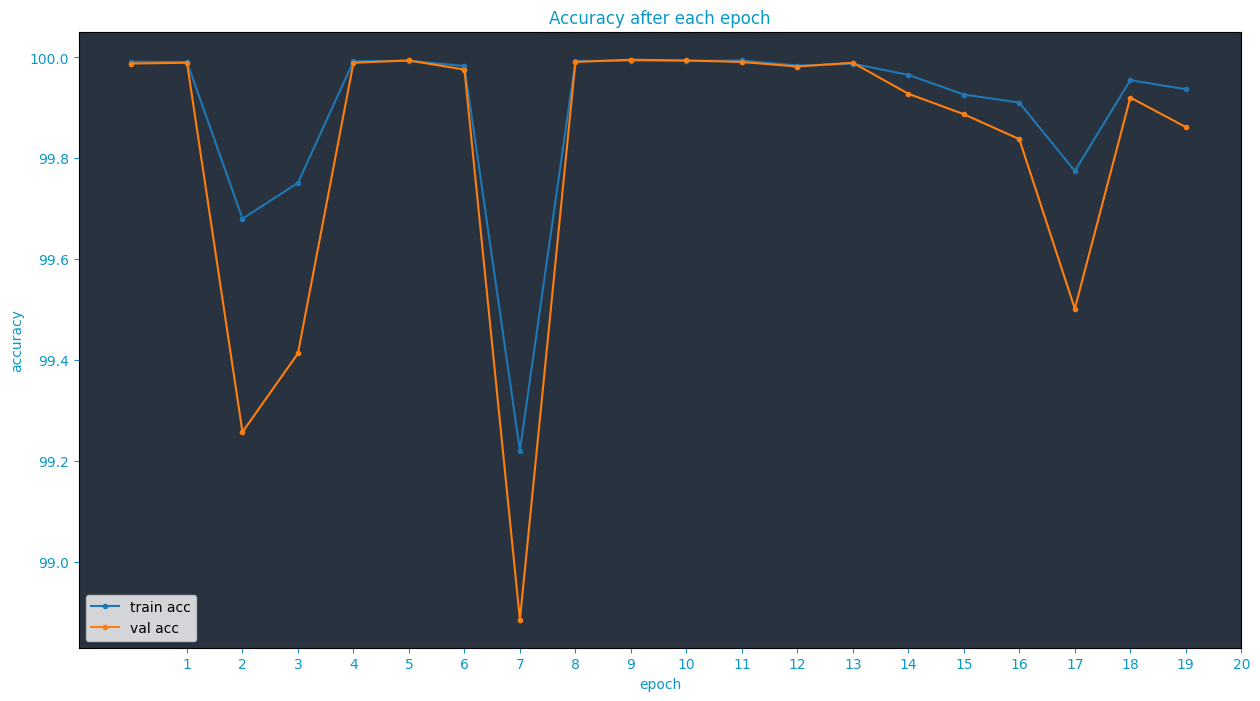

In [ ]:
learning_rate=0.005

conv1d_model=Conv1dNet(
    {
        "vocab_size": len(word_tokenizer.vocab),
        "embedding_dim":50,
        "feature_size":50,
        "window_sizes":[2,3,4],
        "number_of_tags": 2,
        "dropout": 0.2
    }
)
conv1d_model=to_cuda(conv1d_model)

conv1d_dev_accuracies = train(conv1d_model, train_df, dev_df, batch_size=200, epochs=20)
del conv1d_model

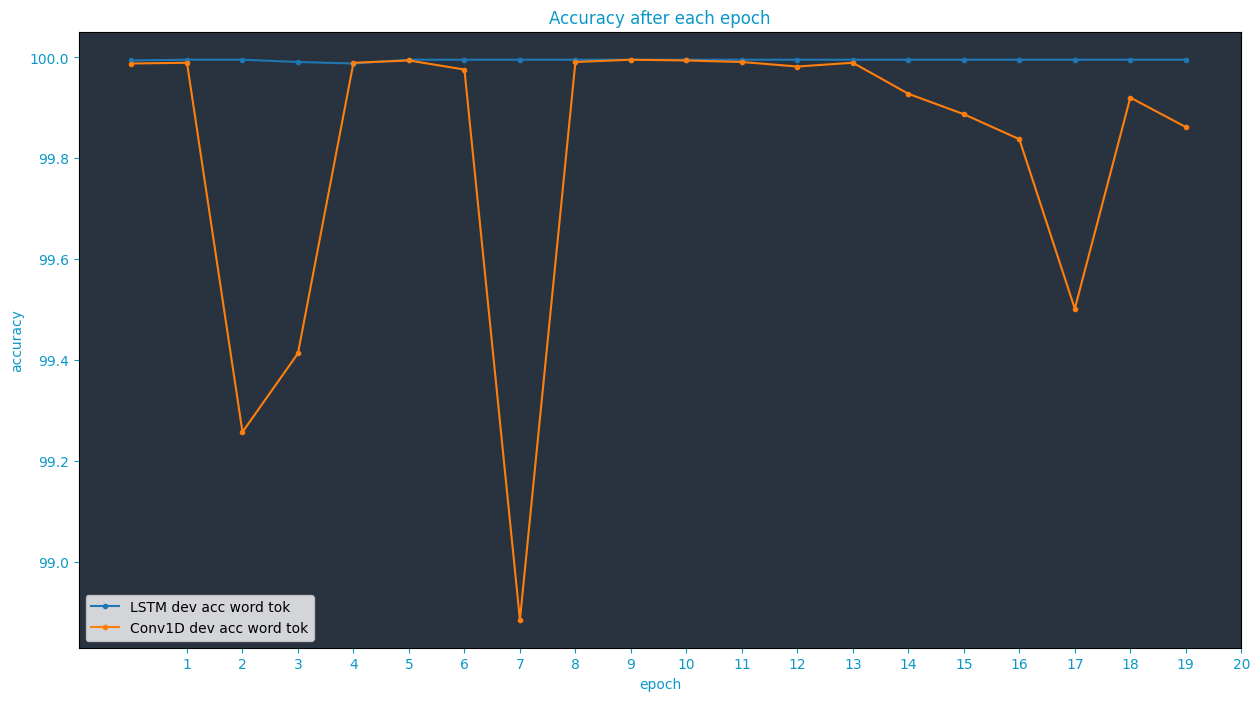

In [ ]:
general_plot([lstm_dev_accuracies,conv1d_dev_accuracies],
             'epoch', 'accuracy', 'Accuracy after each epoch', (8,15),
             ['LSTM dev acc word tok','Conv1D dev acc word tok'])